# IMPORTS

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# LOAD DATASET

In [11]:
import torch
from torchvision import datasets, transforms

# Define the transform to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the train dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=10000, shuffle=True, num_workers= 8)

# Load the test dataset
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers= 8)



# ENCODER

In [12]:
# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 32)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x



# DECODER

In [13]:
# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32, 256)
        self.fc2 = nn.Linear(256, 32 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1,output_padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=x.view(-1, 32, 7, 7)
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=torch.tanh(x)
        
        return x


# AUTOENCODER

In [14]:

# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# PARAMETERS

In [15]:

LEARNING_RATE = 1e-3
NUM_EPOCHS= 1

# MODEL

In [16]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model= model.to(device)

# TRAINING

In [17]:
#import time

In [22]:
#tic = time.time()
for epoch in range(NUM_EPOCHS):
    run_loss = 0.0
    for images, _ in trainloader:
        
        images = images.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()             # Clear the accumulated gradient 
        loss.backward()                   # Backpropogation Calculation
        optimizer.step()                  # Gradient Descent Step
        
        run_loss += loss.item() * images.size(0) 
        
        #print(f"This is loss.item()  : {loss.item()}")
        
        
    
    epoch_loss = run_loss / len(trainset)
    print(f"Epoch : {epoch+1}/{NUM_EPOCHS}, EPOCH Loss: {round(epoch_loss,4)}")
    
#tok = time.time()
#print(f" Time taken : {round((tok-tic),3)} seconds")

Epoch : 1/1, EPOCH Loss: 0.6219
 Time taken : 6.914 seconds


# TRAIN & TEST SET MSE 

In [23]:
# Evaluate the model
model.eval()

total_train_loss = 0.0
with torch.no_grad():
    # Loop over the test data
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)                  # Needed for CUDA
        outputs = model(inputs)                     # Pass images through Autoencoder
        loss = criterion(outputs, inputs)           # MSE Loss
        total_train_loss += loss.item() * inputs.size(0)  # Remove 1/n factor

avg_loss = total_train_loss / len(trainset)
print('Average Test Loss: {:.4f}'.format(avg_loss))


total_test_loss = 0.0
with torch.no_grad():
    # Loop over the test data
    for i, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to(device)                  # Needed for CUDA
        outputs = model(inputs)                     # Pass images through Autoencoder
        loss = criterion(outputs, inputs)           # MSE Loss
        total_test_loss += loss.item() * inputs.size(0)  # Remove 1/n factor

avg_loss = total_test_loss / len(testset)
print('Average Test Loss: {:.4f}'.format(avg_loss))




Average Test Loss: 0.5338
Average Test Loss: 0.5363


In [24]:
total_test_loss = 0.0
all_test_data = []
all_test_data_processed = []

with torch.no_grad():
    # Loop over the test data
    for i, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to(device)                       # Needed for CUDA
        outputs = model(inputs)                          # Pass images through Autoencoder
        loss = criterion(outputs, inputs)                # MSE Loss
        total_test_loss += loss.item() * inputs.size(0)  # Remove 1/n factor
        
        all_test_data.append(inputs)
        all_test_data_processed.append(outputs)
        
avg_loss = total_test_loss / len(testset)
print('Average Test Loss: {:.4f}'.format(avg_loss))


# Concatenate the encoded test data into a single tensor
all_test_data = torch.cat(all_test_data, dim=0)
all_test_data_processed = torch.cat(all_test_data_processed, dim=0)


Average Test Loss: 0.5363


# PLOT BATCH  TO VISUALISE OUTPUT

In [25]:
def plot_batch(batch_input_images, batch_output_images,num_images=64):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from torchvision.utils import make_grid
    
    # Grid from batch
    grid_in = make_grid(batch_input_images[:num_images])
    grid_out = make_grid(batch_output_images[:num_images])
    
    # Convert the grid to a numpy array and transpose the dimensions
    grid_in = grid_in.numpy().transpose((1, 2, 0))
    grid_out = grid_out.numpy().transpose((1, 2, 0))
    
    # Denormalize the pixel values
    grid_in = (grid_in - grid_in.min()) / (grid_in.max() - grid_in.min())
    grid_out = (grid_out - grid_out.min()) / (grid_out.max() - grid_out.min())
    
    # Subplots to see result side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax1.imshow(grid_in)
    ax1.set_title("Original Dataset", fontsize=40)
    
    ax2.imshow(grid_out)
    ax2.set_title("Output Dataset", fontsize=40)
   

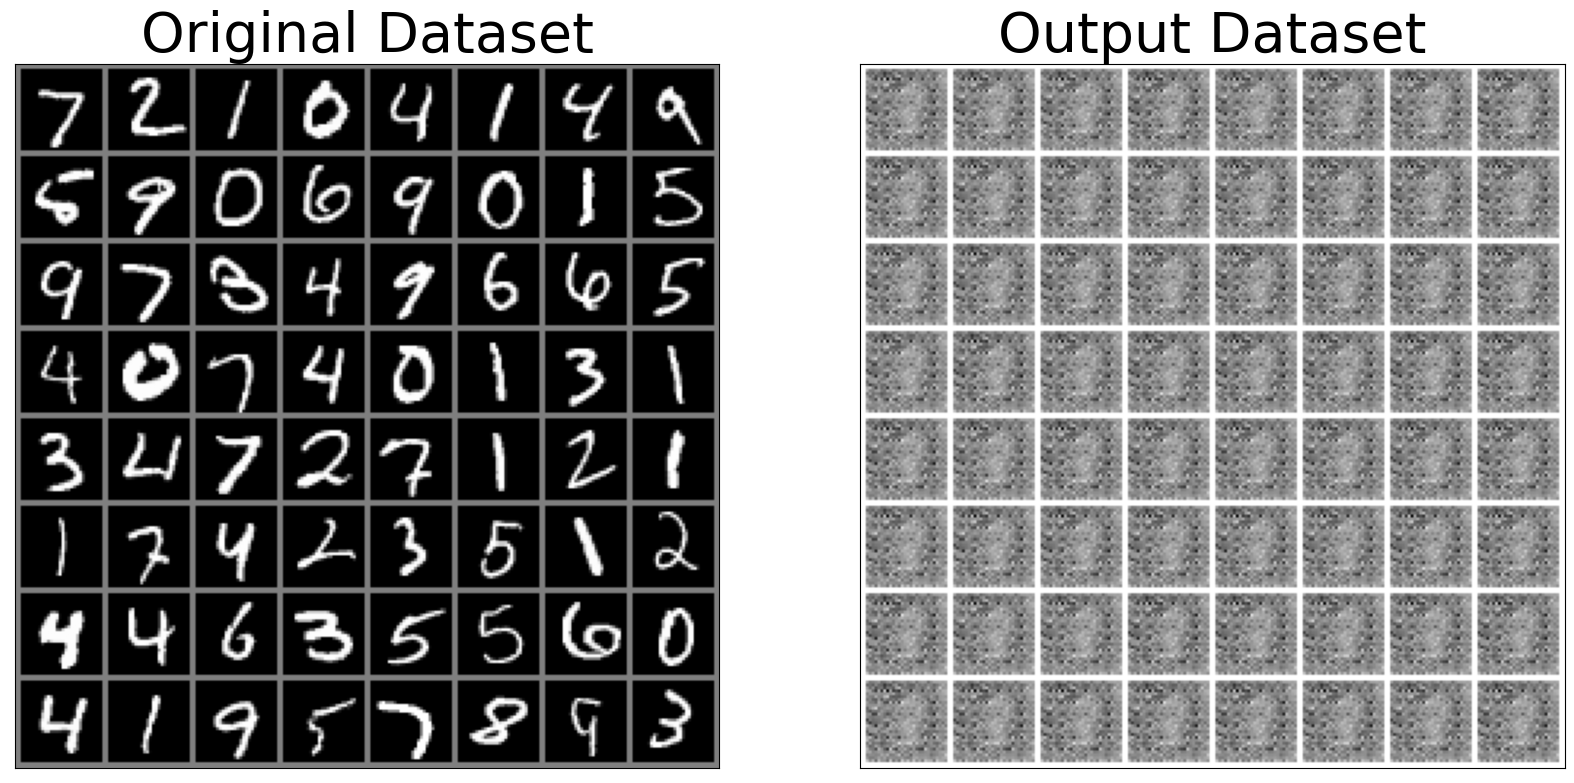

In [26]:
batch_input_images, labels = next(iter(testloader)) # 1st batch of test set
batch_input_images = batch_input_images.to(device)  # Do this if trained on CUDA
batch_output_images = model(batch_input_images)     # Pass batch trough model 

batch_output_images = batch_output_images.cpu()     # Needs this for matplotlib
batch_input_images = batch_input_images.cpu()       # Needs this for matplotlib

plot_batch(batch_input_images, batch_output_images,num_images=64)